In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
from algos.nmcsTimed import *
from algos.nrpasTimed import *
from utils import *
from base import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
filename = "../data/c_memorable_moments.txt"

In [5]:
def get_score(ss_idx):
    ss = Slideshow()
    [ss.add_right(SLIDES[s]) for s in ss_idx]
    return sum(ss.scores)

@timeit
def mean_scores(n, sol, stabilized=False, monitor_time=False, delay=1000):
    scores = []
    for i in range(30):
        if stabilized:
            if monitor_time:
                ss = sol.run(n, verbose=0, stabilized=True, monitor_time=True, delay=delay)
            else:
                ss = sol.run(n, verbose=0, stabilized=True)
        else:
            if monitor_time:
                ss = sol.run(n, verbose=0, monitor_time=True, delay=delay)
            else:
                ss = sol.run(n, verbose=0)
        score = np.sum(ss.scores)
        scores.append(score)
    return np.mean(scores), scores

## NRPA
The first improvement over NMCS that we implemented is NRPA. We will see how it compares with NMCS for different compute times 

In [6]:
initial_time = 0.06
search_times = [initial_time]
for k in range(5):
    search_times.append(initial_time*2)
    initial_time = initial_time*2

In [7]:
NMCS_score = []
NRPA_score = []
for compute_time in search_times:
    # Run NMCS and get the score after compute_time
    sol = NestedMCSolutionTimed(filename, max_slides=50)
    a, b = mean_scores(2, sol, monitor_time=True, delay=compute_time)
    NMCS_score.append(a)
    
    # Run NRPA and get the score after compute_time
    sol = NRPASolutionTimed(filename, max_slides=50)
    sa, sb = mean_scores(2, sol, monitor_time=True, delay=compute_time)
    NRPA_score.append(sa)

df = pd.DataFrame(np.transpose(np.array([search_times, NMCS_score, NRPA_score])), columns=['searchTime','NMCS', 'NRPA'])
display(df)

1000 photos caught.
func:'form_slides' took: 0.0031 sec
Num slides : 750
func:'mean_scores' took: 3.3110 sec
1000 photos caught.
func:'form_slides' took: 0.0156 sec
Num slides : 750
func:'mean_scores' took: 1.9711 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 5.9164 sec
1000 photos caught.
func:'form_slides' took: 0.0103 sec
Num slides : 750
func:'mean_scores' took: 3.7628 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 8.9003 sec
1000 photos caught.
func:'form_slides' took: 0.0101 sec
Num slides : 750
func:'mean_scores' took: 7.4513 sec
1000 photos caught.
func:'form_slides' took: 0.0103 sec
Num slides : 750
func:'mean_scores' took: 15.7958 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 14.6101 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 30.0172 sec
1000 photos caug

,searchTime,NMCS,NRPA
0,0.06,0.000000,14.400000
1,0.12,0.566667,15.233333
2,0.24,1.233333,15.766667
3,0.48,3.466667,17.966667
4,0.96,7.366667,17.866667
5,1.92,16.200000,17.700000


We can see that using our best implementation of NRPA provides better results than our best implementation of NMCS for each compute time.

## Stabilized NRPA

Stabilized NRPA is a simple modification of the NRPA algorithm. It consists in periodically playing P playouts at the lowest level before performing the adaptation.

### Picking a good P value 
We set N=50 and level=2 in order to evaluate an appropriate P value. We iterate through 1 to 10.

In [10]:
from algos.nrpas import *

p_score = []
for p in range(1,10):
    sol = NRPASolution(filename, max_slides=50, N=50, P=p)
    a, b = mean_scores(2, sol, True)
    p_score.append(a)

1000 photos caught.
func:'form_slides' took: 0.0032 sec
Num slides : 750
func:'mean_scores' took: 2.9685 sec
1000 photos caught.
func:'form_slides' took: 0.0185 sec
Num slides : 750
func:'mean_scores' took: 5.1085 sec
1000 photos caught.
func:'form_slides' took: 0.0081 sec
Num slides : 750
func:'mean_scores' took: 6.6355 sec
1000 photos caught.
func:'form_slides' took: 0.0081 sec
Num slides : 750
func:'mean_scores' took: 8.2400 sec
1000 photos caught.
func:'form_slides' took: 0.1317 sec
Num slides : 750
func:'mean_scores' took: 10.2040 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 12.6791 sec
1000 photos caught.
func:'form_slides' took: 0.0156 sec
Num slides : 750
func:'mean_scores' took: 14.9600 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 17.6732 sec
1000 photos caught.
func:'form_slides' took: 0.0156 sec
Num slides : 750
func:'mean_scores' took: 18.2504 sec


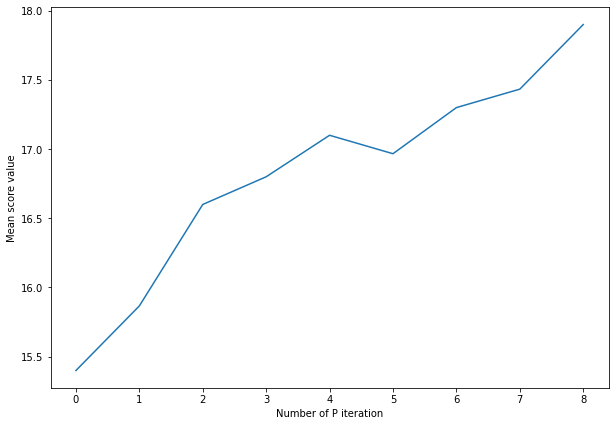

In [11]:
plt.figure(figsize=(10,7))
plt.plot(p_score)
plt.ylabel('Mean score value')
plt.xlabel('Number of P iteration')
plt.show()

Evaluation improves the performance for a growing P value. Thus, P=10 yields the best performance. 

### NRPA vs SNRPA(10)
Let's see with different compute time which algorithm yield the best performance

In [12]:
SNRPA_score = []
NRPA_score = []
for compute_time in search_times:
    # Run NRPA and get the score after compute_time
    sol = NRPASolutionTimed(filename, max_slides=50)
    sa, sb = mean_scores(2, sol, monitor_time=True, delay=compute_time)
    NRPA_score.append(sa)
    
    # Run SNRPA with P=10 and get the score after compute_time
    sol = NRPASolutionTimed(filename, max_slides=50)
    sa, sb = mean_scores(2, sol, True, monitor_time=True, delay=compute_time)
    SNRPA_score.append(sa)
    
df = pd.DataFrame(np.transpose(np.array([search_times,NRPA_score,SNRPA_score])), columns=['computeTime','NRPA_score', 'SNRPA_score'])
display(df)

1000 photos caught.
func:'form_slides' took: 0.0023 sec
Num slides : 750
func:'mean_scores' took: 2.1381 sec
1000 photos caught.
func:'form_slides' took: 0.0156 sec
Num slides : 750
func:'mean_scores' took: 2.0197 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 3.9955 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 3.9670 sec
1000 photos caught.
func:'form_slides' took: 0.0156 sec
Num slides : 750
func:'mean_scores' took: 7.4975 sec
1000 photos caught.
func:'form_slides' took: 0.0156 sec
Num slides : 750
func:'mean_scores' took: 7.5092 sec
1000 photos caught.
func:'form_slides' took: 0.0105 sec
Num slides : 750
func:'mean_scores' took: 14.7263 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 14.6815 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 20.0257 sec
1000 photos caug

,computeTime,NRPA_score,SNRPA_score
0,0.06,14.300000,14.400000
1,0.12,14.500000,14.933333
2,0.24,15.800000,16.433333
3,0.48,16.766667,17.066667
4,0.96,18.400000,18.300000
5,1.92,18.633333,18.233333
